In [ ]:
# Install packages
# Remember to Restart runtime after installation
# Run in ethicon environment

# Change the versions to match the ones present in the docker image
# !pip install itk==5.3rc4
# !pip install vtk
# !pip install itkwidgets
# !pip install icon-registration==0.3.4
# !pip install graphviz
# !pip install tornado==6.1
# !pip install coiled==0.0.76
# !pip install dask==2022.03.0
# !pip install distributed==2022.3.0
# !pip install boto3
# !pip install jupyter
# !pip install pandas==1.4.3
# !pip install numpy==1.21.5
# !pip install lz4==4.0.0
# !pip install git+https://github.com/uncbiag/mermaid.git
# !pip install git+https://github.com/uncbiag/easyreg.git
# !pip install git+https://github.com/PranjalSahu/OAI_analysis_2.git#egg=oai_package

In [1]:
# All Imports

import coiled
import dask
from dask import compute, visualize, delayed

import itk
import vtk
import itkwidgets
from oai_analysis_2 import dask_processing as dp
import matplotlib.pyplot as plt

In [2]:
# Create Coiled Cluster with 2 workers

name = 'oai-processing21'

cluster = coiled.Cluster(
    n_workers=4,
    scheduler_cpu=4,
    scheduler_memory="16 GiB",
    worker_cpu=4,
    worker_memory="16 GiB",
    worker_gpu=1,
    name=name,
    worker_class="dask_cuda.CUDAWorker",
    software="gpu-test9",
)

client = dask.distributed.Client(cluster)

cluster

Output()

Found software environment build
Created fw rule: inbound [8786-8787] [0.0.0.0/0] []
Created FW rules: coiled-dask-pranjal09-154052-firewall
Created fw rule: cluster [0-65535] [None] [coiled-dask-pranjal09-154052-firewall -> coiled-dask-pranjal09-154052-firewall]
Created FW rules: coiled-dask-pranjal09-154052-cluster-firewall
Created fw rule: cluster [0-65535] [None] [coiled-dask-pranjal09-154052-cluster-firewall -> coiled-dask-pranjal09-154052-cluster-firewall]
Created scheduler VM: coiled-dask-pranjal09-154052-scheduler (type: t3.xlarge, ip: ['54.196.182.122'])


Mismatched versions found

+-------------+----------------+----------------+----------------+
| Package     | client         | scheduler      | workers        |
+-------------+----------------+----------------+----------------+
| cloudpickle | 2.0.0          | 2.1.0          | 2.1.0          |
| pandas      | 1.3.1          | 1.4.2          | 1.4.2          |
| python      | 3.8.12.final.0 | 3.9.13.final.0 | 3.9.13.final.0 |
+-------------+----------------+----------------+----------------+


In [75]:
# Main execution block

all_results = []
months_array = ['ENROLLMENT', '12_MONTH', '24_MONTH', '48_MONTH', '72_MONTH', '96_MONTH']
knee_type = 'LEFT_KNEE'
patient_id = '9010060'

for month in months_array:
    image_path = patient_id + '/MR_SAG_3D_DESS/' + knee_type + '/' + month + '/image_preprocessed.nii.gz'

    fc_probmap, tc_probmap = dp.segment_method(image_path)
    phi_AB, image_A, image_B = dp.register_images_delayed(
        image_path, 'atlas_image.nii.gz')

    deformed_fc = dp.deform_probmap_delayed(phi_AB, image_A, image_B,
                                            fc_probmap, 'FC')
    deformed_tc = dp.deform_probmap_delayed(phi_AB, image_A, image_B,
                                            tc_probmap, 'TC')

    thickness_fc = dp.get_thickness(deformed_fc, 'FC')
    thickness_tc = dp.get_thickness(deformed_tc, 'TC')

    result = [thickness_fc, thickness_tc]

    all_results.append(result)

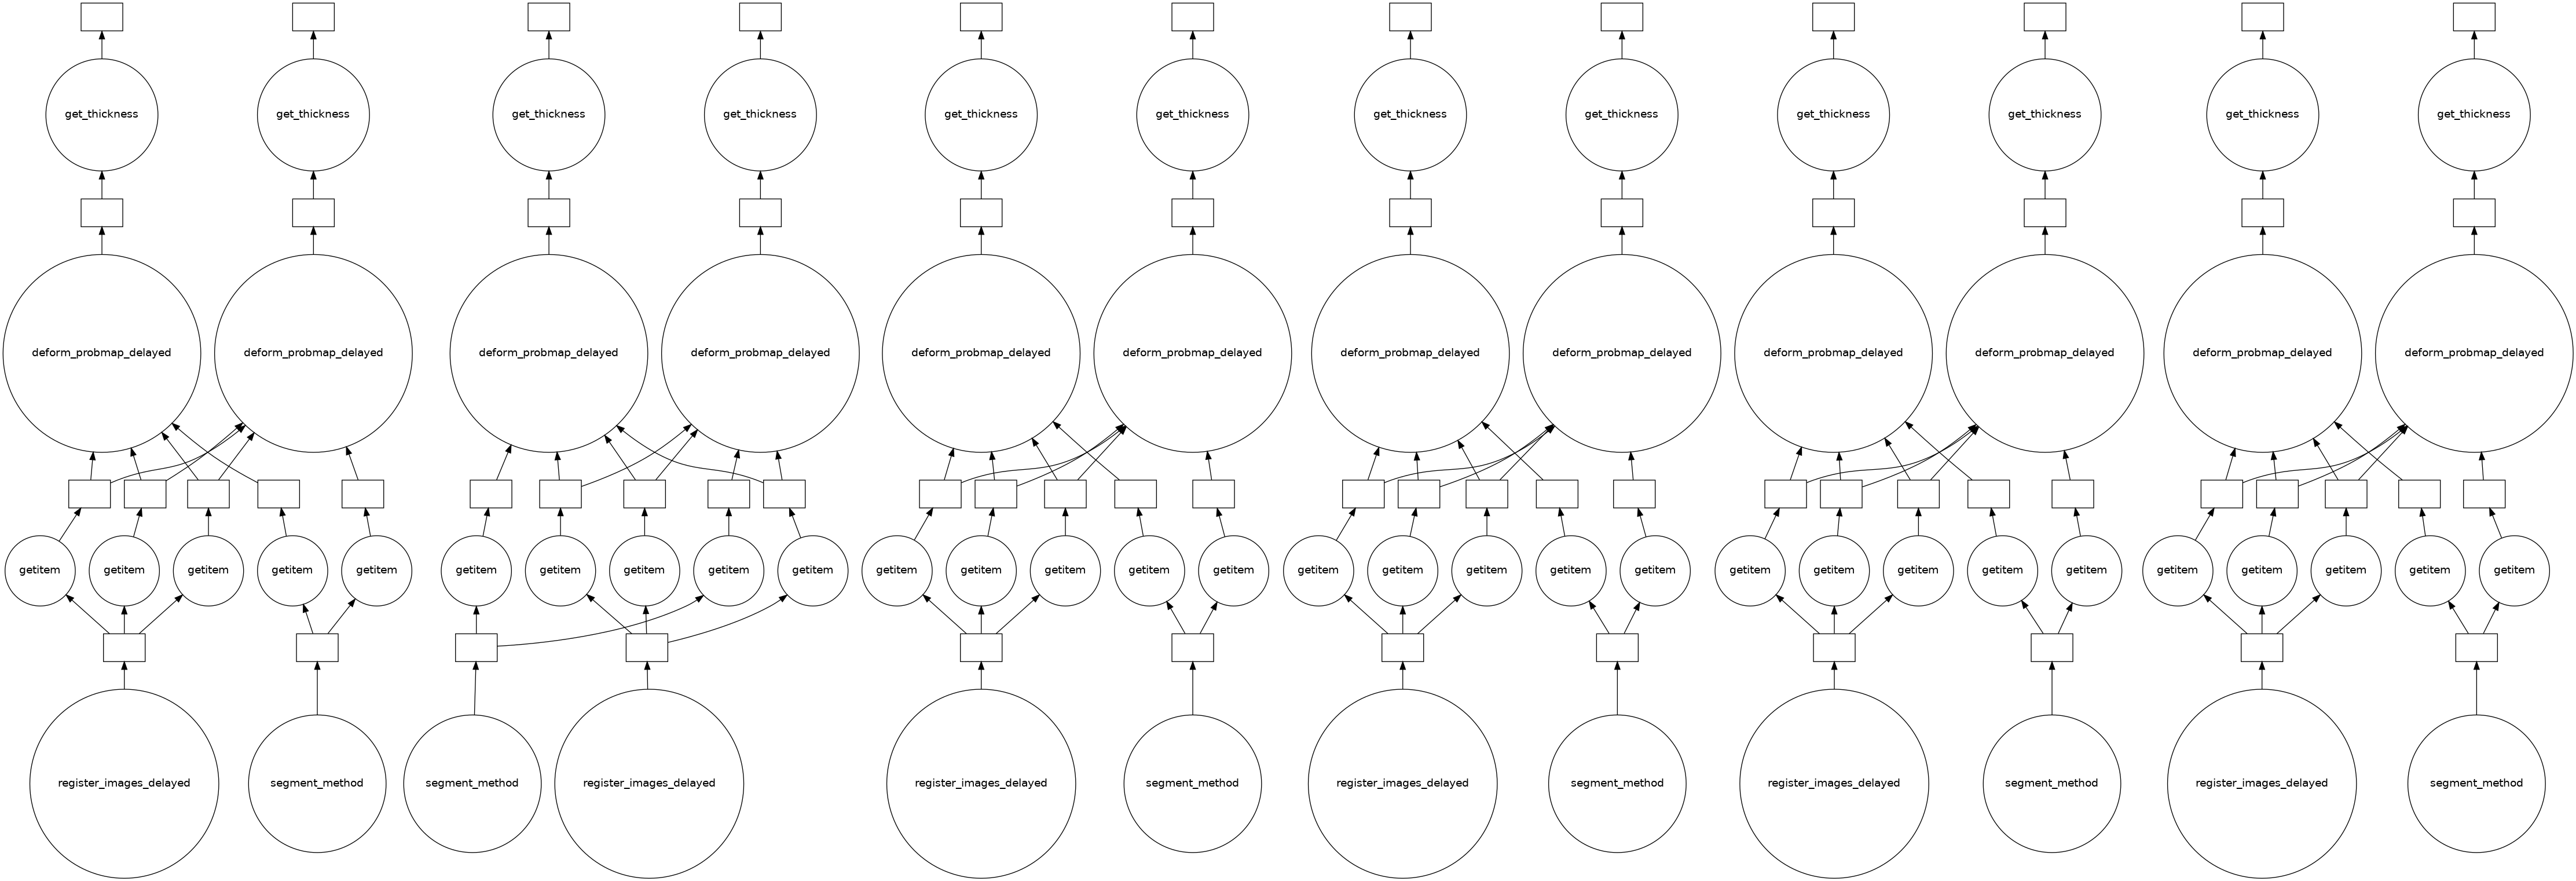

In [76]:
# Visualize Dask Computation Graph

visualize(*all_results)

In [77]:
%%time

output_result = compute(*all_results)

CPU times: user 228 ms, sys: 71.8 ms, total: 300 ms
Wall time: 1min 57s


In [78]:
# Write the meshes as vtk files

for i in range(len(output_result)):
    distance_inner_FC = itk.mesh_from_dict(output_result[i][0])
    distance_inner_TC = itk.mesh_from_dict(output_result[i][1])

    itk.meshwrite(distance_inner_FC, months_array[i]+'_itk_distance_inner_FC.vtk')
    itk.meshwrite(distance_inner_TC, months_array[i]+'_itk_distance_inner_TC.vtk')

In [79]:
# Read the meshes for viewing

month = months_array[5]

v1 = vtk.vtkPolyDataReader()
v1.SetFileName(month+'_itk_distance_inner_FC.vtk')
v1.Update()
m1 = v1.GetOutput()

v2 = vtk.vtkPolyDataReader()
v2.SetFileName(month+'_itk_distance_inner_TC.vtk')
v2.Update()
m2 = v2.GetOutput()

In [80]:
# Visualize the meshes

itkwidgets.view(geometries=[m1, m2])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [10]:
#cluster.close()

Cluster deleted successfully.

2022-06-04 15:12:21,105 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
